In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from torchvision import transforms
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pytesseract import image_to_string

In [4]:
def load_image_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def preprocess(img, w_max, gamma):
    h, w, c = img.shape
    wf, hf = w_max, 1 if int(h*w_max/w) == 0 else int(h*w_max/w)
    img = cv2.resize(img, (wf, hf), interpolation = cv2.INTER_AREA)
    img = 255*(img/255.)**gamma
    img = img.astype(np.uint8)
    return img, (w, h), (wf, hf)

In [5]:
def load_image(image_path, w_max, gamma, hardcoded_range):
    img = load_image_from_path(image_path)
    hd1, hd2 = hardcoded_range
    hardcoded_img = img[hd1: hd2]
    img, (w, h), (wf, hf) = preprocess(img, w_max, gamma)
    hardcoded_img, (_, _), (_, _) = preprocess(hardcoded_img, w_max, gamma)
    wr, hr = wf/w, hf/h
    return img, hardcoded_img, (wf, hf), (wr, hr)

def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img


def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img


In [6]:
def generate_para(img, threshold, kernel_dims):
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    para_list = []
    para_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        para_list.append([x, y, w, h])
        para_images.append(img[y:y+h, x:x+w])
        break
        
    return para_images[0], para_list[0]

In [7]:
def get_img_and_vars(image_path, w_max, gamma, hardcoded_range, threshold, kernel_dims):
    img, himg, (wf, hf), (wr, hr) = load_image(image_path, w_max, gamma, hardcoded_range)
    para_img, (x,y,w,h) = generate_para(himg, threshold, kernel_dims)
    y = y + HARDCODED_RANGE[0]*hr
    y = int(y)
    return img, (x,y,w,h), (x/wf, y/hf, w/wf, h/hf)

In [8]:
image_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])

def return_tensor(image):
    image = fromarray(image)
    return image_transform(image)

---

In [9]:
GAMMA = 2
W_MAX = 1000
THRESHOLD = 40
KERNEL_DIMS = (85,85)
HARDCODED_RANGE = (710,2800)

In [10]:
image_path = '/kaggle/input/iam-handwritten-forms-dataset/data/000/a01-000u.png'

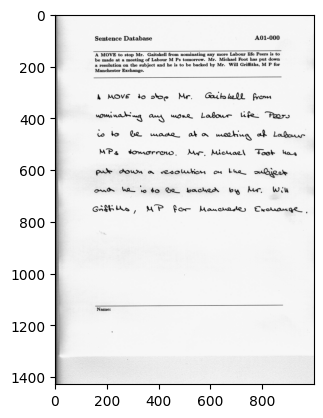

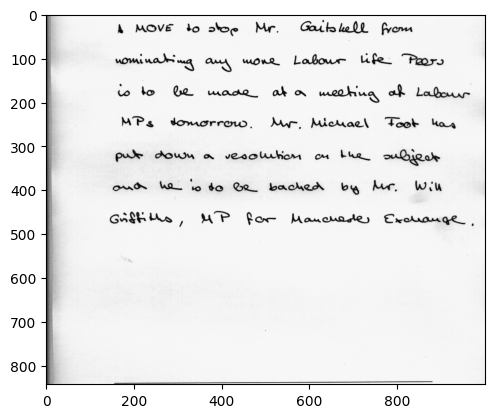

In [11]:
img, himg, (wf, hf), (wr, hr) = load_image(image_path, W_MAX, GAMMA, HARDCODED_RANGE)
plt.imshow(img)
plt.show()
plt.imshow(himg)
plt.show()

In [ ]:
para_img, (x,y,w,h) = generate_para(himg, THRESHOLD, KERNEL_DIMS)
plt.imshow(para_img)
y = y + HARDCODED_RANGE[0]*hr
y = int(y)
print((x,y,w,h))
plt.show()

(104, 286, 896, 527)


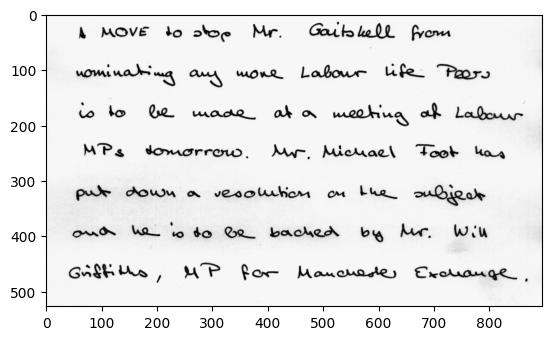

In [13]:
plt.imshow(img[y:y+h, x:x+w])
plt.show()

In [14]:
img, (x,y,w,h), _ = get_img_and_vars(image_path, W_MAX, GAMMA, HARDCODED_RANGE, THRESHOLD, KERNEL_DIMS)

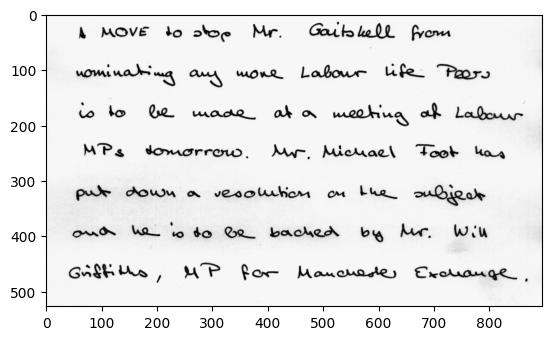

In [15]:
plt.imshow(img[y:y+h, x:x+w])
plt.show()

In [ ]:
maindir = '/kaggle/input/iam-handwritten-forms-dataset/data'
for subdir in os.listdir(maindir):
    subdir_path = os.path.join(maindir, subdir)
    for img_file in os.listdir(subdir_path):
        img_file_path = os.path.join(subdir_path, img_file)
        print(img_file_path)
        img, himg, (wf, hf), (wr, hr) = load_image(img_file_path, W_MAX, GAMMA, HARDCODED_RANGE)
        para_img, (x,y,w,h) = generate_para(himg, THRESHOLD, KERNEL_DIMS)
        y = y + HARDCODED_RANGE[0]*hr
        y = int(y)
        plt.imshow(img[y:y+h, x:x+w])
        plt.show()
        break
    break

/kaggle/input/iam-handwritten-forms-dataset/data/515/m01-115.png


In [17]:
df = pd.read_csv('/kaggle/input/paraseg-data/paraseg.csv')

In [18]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.image_paths = df['image_path'].tolist()
        x = df['x'].tolist()
        y = df['y'].tolist()
        w = df['w'].tolist()
        h = df['h'].tolist()
        
        labels = np.array([x, y, w, h])
        self.labels = labels.T.tolist()

    def __len__(self):
        return df.shape[0]
    
    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx], self.labels[idx]
        img = load_image_from_path(img_path)
        img, _, _ = preprocess(img, W_MAX, GAMMA)
        img_tensor = return_tensor(img)
        return img_tensor, label

In [19]:
dataset = CustomDataset(df)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [20]:
for each in data_loader:
    img = each[0][0]
    x = each[1][0][0]
    y = each[1][1][0]
    w = each[1][2][0]
    h = each[1][3][0]
    print(img.shape)
    print(x,y,w,h)
    break

torch.Size([1, 1428, 1000])
tensor(0.0940, dtype=torch.float64) tensor(0.2003, dtype=torch.float64) tensor(0.8550, dtype=torch.float64) tensor(0.5735, dtype=torch.float64)


In [21]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()

        # Load pre-trained ResNet34 model
        self.resnet = models.resnet34(pretrained=True)

        # Modify the first convolutional layer to accommodate grayscale images
        conv1_weight = self.resnet.conv1.weight.data
        conv1_weight = conv1_weight.mean(dim=1, keepdim=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1.weight.data = conv1_weight

        # Remove the last fully connected layer of ResNet34
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Freeze the ResNet layers so they won't be trained
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Add fully connected layers
        self.fc1 = nn.Linear(512, 64)  # ResNet34 outputs 512 features
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)  # Output layer with 4 units for bounding box coordinates
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through ResNet layers
        x = self.resnet(x)

        # Flatten the output of ResNet
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)  # Applying sigmoid activation for bounding box coordinates

        return x

In [22]:
resnet = ResNet34()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 54.1MB/s]


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34().to(device)
model.load_state_dict(torch.load('/kaggle/input/htr-model/model.pth'))

<All keys matched successfully>

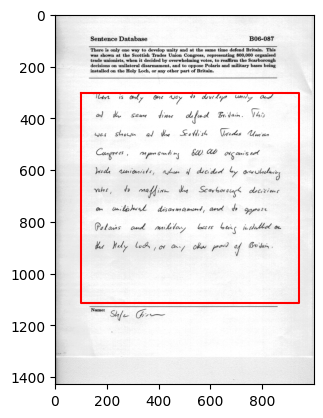

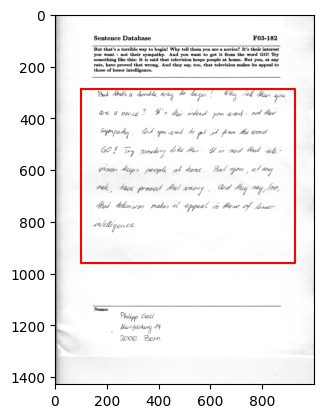

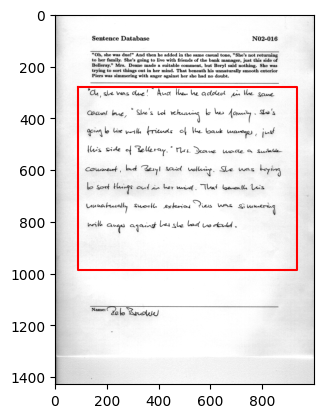

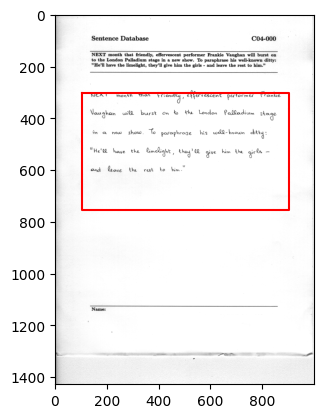

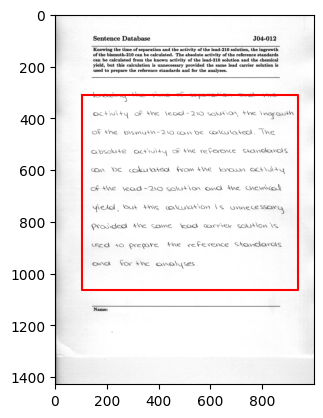

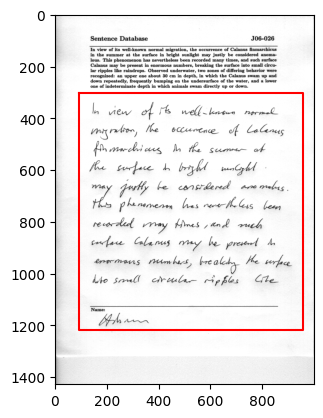

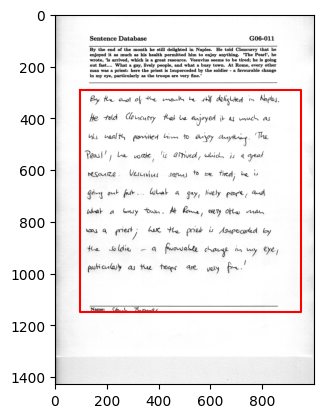

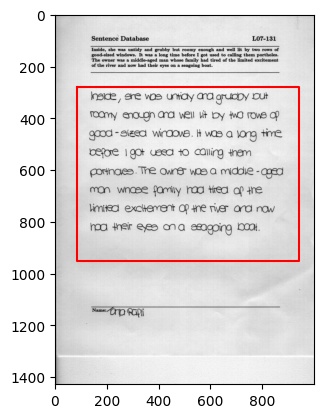

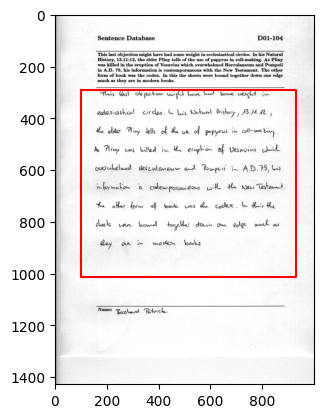

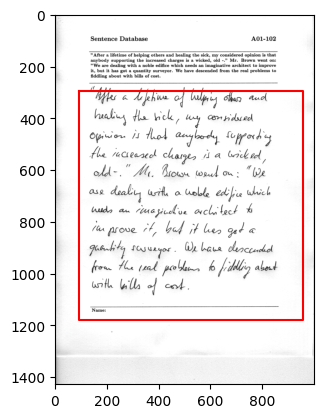

In [24]:
for images, _ in data_loader:
    images = images.to(device)
    y_hat = model(images)
    break
    
for i in range(10):
    x, y, w, h = y_hat[i].detach()

    x = x.cpu().numpy()
    y = y.cpu().numpy()
    w = w.cpu().numpy()
    h = h.cpu().numpy()

    image = images[i]

    height, width = image.shape[1], image.shape[2]

    x_left_top, y_left_top = x * width, y * height
    width, height = w * width, h * height

    x_right_top = x_left_top + width
    y_left_bottom = y_left_top + height
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.plot([x_left_top, x_left_top, x_right_top, x_right_top, x_left_top],
             [y_left_top, y_left_bottom, y_left_bottom, y_left_top, y_left_top],
             color='red')
    

    plt.show()

In [25]:
def crop_images(images, y_hat):
    cropped_images = []
    max_width = -1
    max_height = -1

    for i in range(y_hat.shape[0]):  # Loop over each image in the batch
        x, y, w, h = y_hat[i].detach().cpu().numpy()  # Get bounding box coordinates for the ith image
        image = images[i].cpu().squeeze()  # Get the ith image from the batch

        height, width = image.shape[0], image.shape[1]

        x_left_top, y_left_top = int(x * width), int(y * height)
        width, height = int(w * width), int(h * height)
        x_right_top = x_left_top + width
        y_left_bottom = y_left_top + height

        # Get the cropped image
        cropped_image = image[y_left_top:y_left_bottom, x_left_top:x_right_top]

        # Update max_width and max_height
        max_width = max(max_width, width)
        max_height = max(max_height, height)

        cropped_images.append(cropped_image)

    # Resize each cropped image to the maximum width and height
    resize_transform = transforms.Resize((max_height, max_width))

    resized_images = [resize_transform(torch.unsqueeze(img, 0)) for img in cropped_images]
    
    # Stack the resized images
    stacked_images = torch.stack(resized_images)
    
    return stacked_images

In [26]:
for images, y_hat in data_loader:
    images = images.to(device)
    y_hat = model(images)
    cropped_images = crop_images(images, y_hat)
    break

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


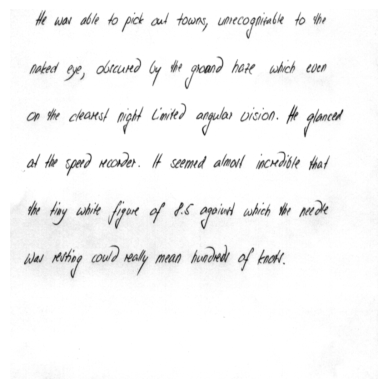

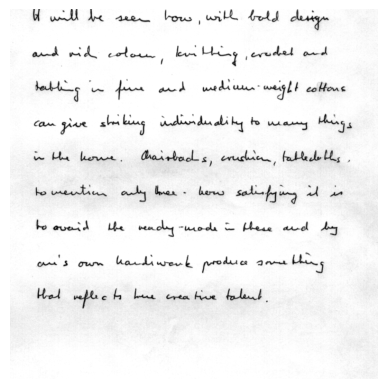

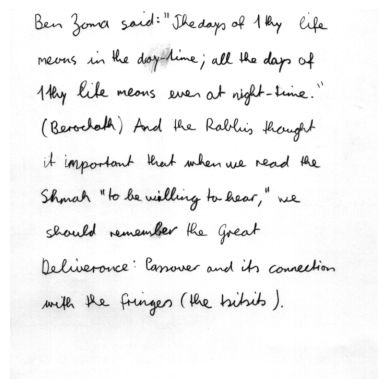

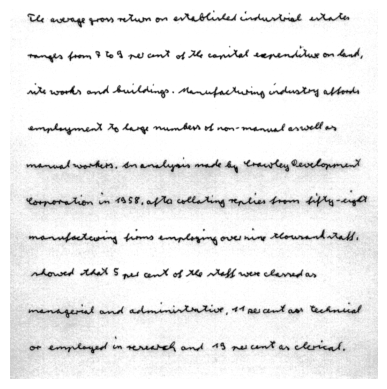

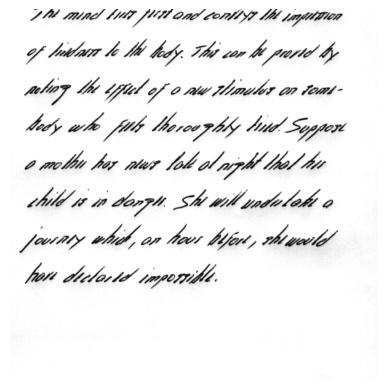

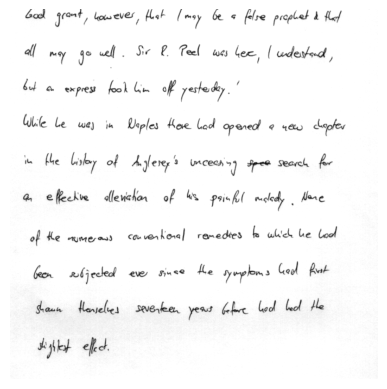

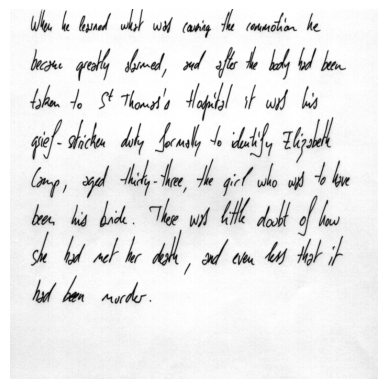

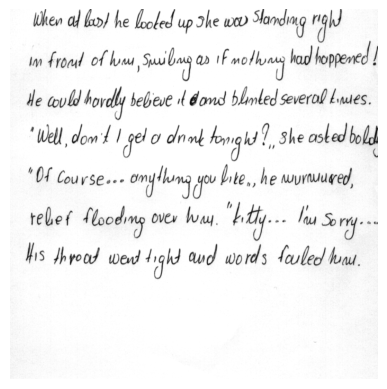

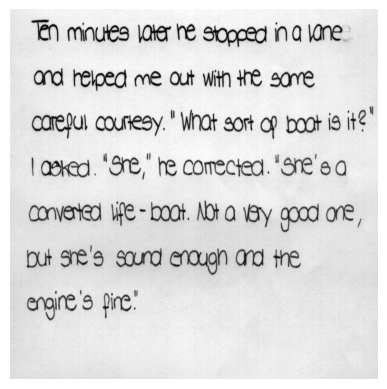

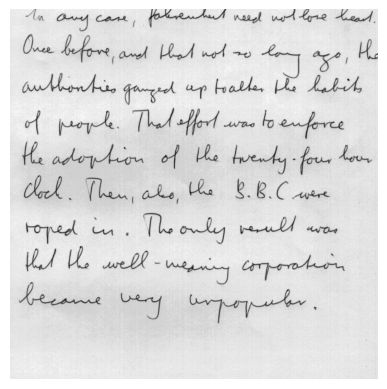

In [27]:
for i in range(10):
    image = cropped_images[i].squeeze()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [28]:
!pip install transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from IPython.display import display
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten") 
trcocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

2024-04-09 06:32:32.100825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 06:32:32.100937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 06:32:32.235400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [183]:
def ocr_image(img):
    pixel_values = processor(images=img, return_tensors="pt").pixel_values
    generated_ids = trcocr_model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [184]:
tensor_to_img_transform = transforms.ToPILImage()

def line_to_text(line_img_tensor):
    line_img = tensor_to_img_transform(line_img_tensor)
    text = image_to_string(line_img)
    return text

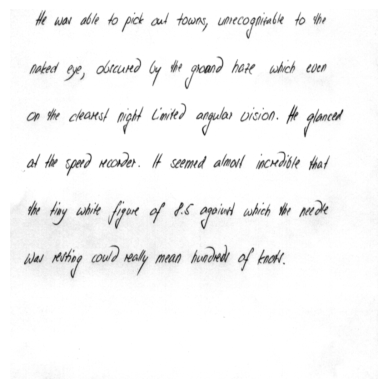

He wa able to pick oud town, umecogninbk to the
foled oe, obteund 4 he pen hate whch even
op the clears} ng Linted aig vision. fe led
a Me speed neorder. I seemed alnol ncrdibie had
th tay cake fy of ts apoind abich the nee

Wal stay awd wal mean funded of tad



In [185]:
for i in range(1):
    image = cropped_images[i].squeeze()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
print(line_to_text(cropped_images[0]))

In [186]:
def preprocess(img, w_max, gamma):
    h, w, c = img.shape
    wf, hf = w_max, 1 if int(h*w_max/w) == 0 else int(h*w_max/w)
    img = cv2.resize(img, (wf, hf), interpolation = cv2.INTER_AREA)
    img = 255*(img/255.)**gamma
    img = img.astype(np.uint8)
    return img, (w, h), (wf, hf)

In [187]:
def tensor_to_cvarray(img_tensor):
    img = tensor_to_img_transform(img_tensor)
    cv_img = np.array(img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    return cv_img

In [188]:
def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img


def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img

In [189]:
from statistics import median

In [248]:
def return_tensor(image, w, h):
    image = fromarray(image)
    image = transforms.Compose([transforms.Resize((h,w)), transforms.Grayscale(), transforms.ToTensor()])(image)
    return image

In [257]:
def generate_lines(img_tensor, w_max, gamma, threshold, kernel_dims, num_lines_threshold=4):
    img = tensor_to_cvarray(img_tensor)
    img, _, _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    lines_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        if w >= 100 and h >= 20 and area>=10000:
            lines_images.append(img[y:y+h, x:x+w])
            
    if len(lines_images) <= num_lines_threshold:
        lines_images = []
    
    lines_tensor_list = []
    lines_text_list = []
    for each in lines_images:
        lines_tensor_list.append(return_tensor(each, 900, 30))
        lines_text_list.append(ocr_image(each))
    
    return lines_tensor_list, lines_text_list

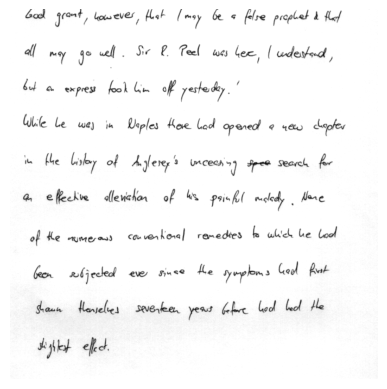

In [222]:
image = cropped_images[5].squeeze()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [206]:
LINE_KERNEL_DIMS = (20,800)

In [258]:
lines = generate_lines(cropped_images[0], W_MAX, 1, THRESHOLD, LINE_KERNEL_DIMS)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


torch.Size([1, 30, 900])
# He was able to pick out towns, unrecognitable to the


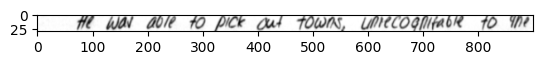

--------------------------------------------------
torch.Size([1, 30, 900])
naked eye, obscured by the ground hotel which even


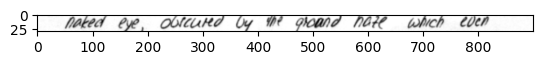

--------------------------------------------------
torch.Size([1, 30, 900])
on the clearest night limited angular vision. He glenced


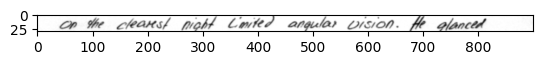

--------------------------------------------------
torch.Size([1, 30, 900])
the other other projects


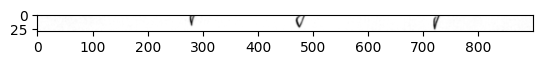

--------------------------------------------------
torch.Size([1, 30, 900])
at the speed recorder. It seemed almost incredible that


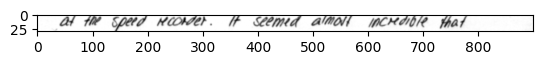

--------------------------------------------------
torch.Size([1, 30, 900])
the tiny white figure of 8.5 against which the needle


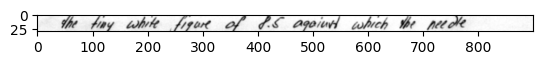

--------------------------------------------------
torch.Size([1, 30, 900])
# #


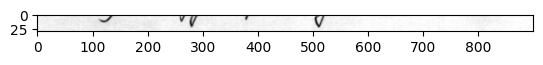

--------------------------------------------------
torch.Size([1, 30, 900])
was resting could really mean hundreds of knots.


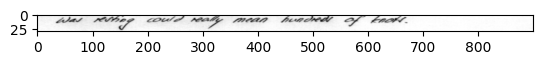

--------------------------------------------------


In [255]:
for each in lines:
    print(each[0].shape)
#     print(each[0])
    plt.imshow(each[0].permute(1,2,0), cmap='gray')
    print(each[1])
    plt.show()
    print('-'*50)

In [259]:
stacked = torch.stack(lines[0])

In [260]:
stacked.shape

torch.Size([8, 1, 30, 900])